In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cmap_reds = plt.cm.get_cmap('Reds')
sns.set_palette('Reds')

#### Raspagem: lista de mulheres nomeadas e ganhadoras do Oscar em categorias em que gêneros competem.

**Obs.: Essa foi uma raspagem inicial de uma página da Wikipedia. No projeto final, a fonte usada foi a base de dados do Oscar mostrada mais abaixo.**

Como alguns elementos ocupam mais que uma linha, não é possível fazer a raspagem iterando entre os múltiplos de cada célula. A solução encontrada foi:

- Para o ano ('year'): tentar converter os 4 primeiros caracteres da célula em inteiro. Se não houver erro, é porque a célula é um ano válido; ele é salvo na variável `new_year`.
- Para o status ('Nominated' ou 'Won'): todas as células de status possuem `<td class="no table-no2" (...)>` para _Nominated_ ou `<td class="yes table-yes2" (...)>` para _Won_. Verifica-se se a célula atual é uma dessas e, se sim, o texto dela, da categoria (título da tabela) e do ano `new_year` é adicionado em suas respectivas listas.


In [3]:
url = "https://en.wikipedia.org/wiki/List_of_female_Academy_Award_winners_and_nominees_for_non-gendered_categories"
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

year = []
category = []
status = []
all_tables = soup.find_all(class_='wikitable')

for table in all_tables:
	td = table.find_all('td')
	new_year = 0
	for i in range(0, len(td)):
		try:
			old_year = new_year
			new_year = int(td[i].text[0:4])
			if new_year < 1000:
				new_year = old_year
		except ValueError:
			pass
		if td[i].get('class'):
			status.append(td[i].text[0:-1])
			category.append(td[0].text[18:-1])
			if new_year != 0:
				year.append(new_year)

oscar_women_df = pd.DataFrame({
	'year': year,
	'category': category,
	'status': status
})

#	renomeia as categorias que possuíam sobrescrito no título.
oscar_women_df.category = oscar_women_df.category.replace({
	'Best Sound [note 12]': 'Best Sound Mixing',
	'Best Original Score [note 7]': 'Best Original Score'
})

#	corrige um typo na tabela original.
oscar_women_df.status = oscar_women_df.status.replace({'Nominated}': 'Nominated'})


# Raspagem: [base de dados da Academia de Artes e Ciências Cinematográficas](https://awardsdatabase.oscars.org/).
Devido à dinamicidade do site, para a automação completa seria necessária o uso do Selenium. Para os fins do projeto, o código da página de busca avançada foi salvo nos arquivos `nominees-men.html` e `nominees-women.html`. As páginas possuem as seguintes categorias:

1. DIRECTING
2. BEST PICTURE
3. FILM EDITING
4. WRITING
5. COSTUME DESIGN
6. DOCUMENTARY (Feature)
7. CINEMATOGRAPHY
8. SHORT FILM

Obs.: Quando alguém é indicado por dois filmes no mesmo ano, somente o primeiro filme é minerado (e terminado por ';'). Como a análise é focada na pessoa nomeada e não no filme, essa questão não foi tratada.

In [4]:
# Cria o dataframe para páginas de buscas com múltiplas categorias.
def get_oscar_df(file):
	f = open(file)
	soup = BeautifulSoup(f, 'html.parser')
	df = pd.DataFrame({'year': [], 'category': [], 'film': [], 'name': [], 'status': []})

	all_groups = soup.find_all(class_='awards-result-chron result-group group-awardcategory-chron')
	for group in all_groups:
		year = group.find(class_="result-group-title").text.strip()[0:4]
		all_categories = group.find_all(class_="result-subgroup subgroup-awardcategory-chron")
		for each_category in all_categories:
			category = each_category.find(class_="result-subgroup-title").text.strip()

			if category.split()[0] == 'SHORT':
				all_films = each_category.find_all(class_="result-details awards-result-other")
			else:
				all_films = each_category.find_all(class_="result-details awards-result-actingorsimilar")
			for row in all_films:
				try:
					film = row.find(class_="awards-result-film-title").text.strip()
				except AttributeError:
					film = 'Error'
				if row.find(class_="glyphicon glyphicon-star"):
					status = 'winner'
				else:
					status = 'nominated'
				all_names = re.split(r'; |: | and | & | by |, ', row.find(class_="awards-result-nominationstatement").text)
				for name in all_names:
					name = name.strip(' \n()')
					row = pd.DataFrame({'year': [year],
										'category': [category],
										'film': [film],
										'name': [name],
										'status': [status]
										})
					df = pd.concat([df, row], ignore_index=True)

	to_remove = ['Jr.', 'Producer', 'Producers', 'Adaptation', 'Art Direction',
				 'Interior Decoration', 'Set Decoration', 'Production Design',
				 'Screenplay', 'Written', 'Story', 'Stories',
				 'Adapted for the screen', 'Written for the screen']
	df = df[df.film != 'Error']
	df = df[-df.name.isin(to_remove)]
	f.close()
	return df

# padroniza os nomes das categorias
def clean_categories(df):
	for row in df.category:
		words = row.split()
		if words[0] == 'DIRECTING':
			df.category = df.category.replace({row: 'DIRECTING'})
		elif words[0] == 'WRITING':
			df.category = df.category.replace({row: 'WRITING'})
		elif words[0] == 'ART':
			df.category = df.category.replace({row: 'ART DIRECTION'})
		elif words[0] == 'CINEMATOGRAPHY':
			df.category = df.category.replace({row: 'CINEMATOGRAPHY'})
		elif words[0] == 'COSTUME':
			df.category = df.category.replace({row: 'COSTUME DESIGN'})
		elif words[0] == 'SPECIAL':
			df.category = df.category.replace({row: 'VISUAL EFFECTS'})
		elif words[0] == 'SOUND':
			df.category = df.category.replace({row: 'SOUND'})
		elif words[0] == 'SHORT':
			df.category = df.category.replace({row: 'SHORT FILM'})
		elif words[1] == 'MOTION':
			df.category = df.category.replace({row: 'BEST PICTURE'})
	return df


In [8]:
# salva para csv:
# women_df = get_oscar_df('oscar-pages/nominees-women.html')
# men_df = get_oscar_df('oscar-pages/nominees-men.html')
# women_df.to_csv('oscar-datasets/oscar-women-v0.csv', index=False)
# men_df.to_csv('oscar-datasets/oscar-men-v0.csv', index=False)


#### Limpando os datasets.
Para categorias em que homens e mulheres eram indicados pelo mesmo filme, os indicados apareciam tanto na busca por homens quanto por mulheres. escolheu-se então usar o pacote [`gender-guesser`](https://pypi.org/project/gender-guesser/) para limpar os nomes masculinos da tabela feminina e vice-versa.

Por esse método, 379 mulheres foram removidas do dataset masculino, e 501 homens do dataset feminino. Alguns nomes foram indicados mais de uma vez, então a alteração no tamanho dos datasets foi maior.

In [9]:
women_df = pd.read_csv('oscar-datasets/oscar-women-v0.csv')
men_df = pd.read_csv('oscar-datasets/oscar-men-v0.csv')

g = gender.Detector()

female_names = []
male_names = []

for name in women_df.name.unique():
	first_name = name.split()[0]
	if g.get_gender(first_name) == 'male' or g.get_gender(first_name) == 'mostly_male':
		male_names.append(name)
women_df = women_df[-women_df.name.isin(male_names)]

for name in men_df.name.unique():
	first_name = name.split()[0]
	if g.get_gender(first_name) == 'female' or g.get_gender(first_name) == 'mostly_female':
		female_names.append(name)
men_df = men_df[-men_df.name.isin(female_names)]

# converte anos para int
women_df.year.astype(int)
men_df.year.astype(int)

print("Qntd. de nomes femininos removidos: %d" % len(female_names))
print("Qntd. de nomes masculinos removidos: %d" % len(male_names))

# padroniza as categorias:
men_df = clean_categories(men_df)
women_df = clean_categories(women_df)

Qntd. de nomes femininos removidos: 342
Qntd. de nomes masculinos removidos: 442


In [10]:
# salva os datasets tratados em um csv
# women_df.to_csv('oscar-datasets/oscar-women-v1.csv', index=False)
# men_df.to_csv('oscar-datasets/oscar-men-v1.csv', index=False)

In [11]:
# adiciona a coluna gender em cada um
women_df['gender'] = 'female'
men_df['gender'] = 'male'

# une os datasets e coloca-o em ordem cronológica
# oscar_df = pd.concat([women_df, men_df])
# oscar_df = oscar_df.sort_values(by='year')

# salva em um dataset final
# oscar_df.to_csv('oscar-datasets/oscar_dataset.csv', index=False)


# Visualização dos dados


In [12]:
women_df = pd.read_csv('oscar-datasets/oscar-women-v1.csv')
men_df = pd.read_csv('oscar-datasets/oscar-men-v1.csv')

In [13]:
oscar_df = pd.read_csv('oscar-datasets/oscar_dataset.csv')

# adiciona uma nova coluna que une gênero e status para facilitar plotagem.
hue = []
for index, row in oscar_df.iterrows():
	hue.append(row.gender + ' ' + row.status)

oscar_df['hue'] = hue

In [14]:
oscar_df

,year,category,film,name,status,gender,hue
0,1927,CINEMATOGRAPHY,The Devil Dancer;,George Barnes,nominated,male,male nominated
1,1927,WRITING,The Private Life of Helen of Troy,Gerald Duffy,nominated,male,male nominated
2,1927,WRITING,Underworld,Ben Hecht,winner,male,male winner
3,1927,WRITING,The Last Command,Lajos Biro,nominated,male,male nominated
4,1927,WRITING,7th Heaven,Benjamin Glazer,winner,male,male winner
...,...,...,...,...,...,...,...
5853,2021,WRITING,The Power of the Dog,Jane Campion,nominated,female,female nominated
5854,2021,WRITING,The Worst Person in the World,Eskil Vogt,nominated,male,male nominated
5855,2021,COSTUME DESIGN,Cruella,Jenny Beavan,winner,female,female winner
5856,2021,COSTUME DESIGN,Nightmare Alley,Luis Sequeira,nominated,male,male nominated



#### Indicações
- Cinematografia é a categoria mais desigual: apenas 1 mulher indicada (0.15%), em 2017. Seguida por Direção (1.76%), com apenas 8 indicadas e 3 ganhadoras, duas das quais nos últimos três anos.
- Design de figurino é a única categoria majoritariamente feminina - 57.46% dos indicados são mulheres

Obs.: A biblioteca gender-guesser descartou o nome de Ari Wegner indicada a cinematografia em 2021. A porcentagem correta é portanto de 0.29%

In [15]:
# INDICADAS
print("Porcentagem de mulheres indicadas:")
for category in set(oscar_df.category):
	total_category = len(oscar_df[oscar_df.category == category])
	women_total = len(oscar_df[(oscar_df.gender == 'female') &
							   (oscar_df.category == category)])
	percent = (women_total / total_category) * 100
	print("%s: %.2f%%" % (category, percent))
	# print("%s: %.2f%%. Total: %d, Mulheres:  %d" % (category, percent,
	# 												total_category, women_total))

Porcentagem de mulheres indicadas:
WRITING: 11.00%
SHORT FILM: 16.46%
DIRECTING: 1.76%
COSTUME DESIGN: 57.46%
FILM EDITING: 13.76%
CINEMATOGRAPHY: 0.15%
DOCUMENTARY (Feature): 27.40%
BEST PICTURE: 16.67%


In [16]:
# GANHADORAS
print("\nPorcentagem de mulheres entre ganhadores:")
for category in set(oscar_df.category):
	total_category = len(oscar_df[(oscar_df.category == category) &
								  (oscar_df.status == 'winner')])
	women_total = len(oscar_df[(oscar_df.gender == 'female') &
							   (oscar_df.category == category) &
							   (oscar_df.status == 'winner')])
	percent = (women_total / total_category) * 100
	print("%s: %.2f%%" % (category, percent))
	# print("%s: %.2f%%. Total: %d, Mulheres:  %d" % (category, percent,
	# 												total_category, women_total))


Porcentagem de mulheres entre ganhadores:
WRITING: 8.11%
SHORT FILM: 15.22%
DIRECTING: 3.26%
COSTUME DESIGN: 60.33%
FILM EDITING: 12.07%
CINEMATOGRAPHY: 0.00%
DOCUMENTARY (Feature): 18.60%
BEST PICTURE: 10.64%


In [17]:
# MELHOR CINEMATOGRAFIA
oscar_df[(oscar_df.category == 'CINEMATOGRAPHY') &
		 (oscar_df.gender == 'female')]

,year,category,film,name,status,gender,hue
5448,2017,CINEMATOGRAPHY,Mudbound,Rachel Morrison,nominated,female,female nominated


In [18]:
# MELHOR DIREÇÃO
oscar_df[(oscar_df.category == 'DIRECTING') &
		 (oscar_df.gender == 'female')]

,year,category,film,name,status,gender,hue
2587,1976,DIRECTING,Seven Beauties,Lina WertmÃ¼ller,nominated,female,female nominated
3648,1993,DIRECTING,The Piano,Jane Campion,nominated,female,female nominated
4332,2003,DIRECTING,Lost in Translation,Sofia Coppola,nominated,female,female nominated
4751,2009,DIRECTING,The Hurt Locker,Kathryn Bigelow,winner,female,female winner
5444,2017,DIRECTING,Lady Bird,Greta Gerwig,nominated,female,female nominated
5749,2020,DIRECTING,Nomadland,ChloÃ© Zhao,winner,female,female winner
5750,2020,DIRECTING,Promising Young Woman,Emerald Fennell,nominated,female,female nominated
5834,2021,DIRECTING,The Power of the Dog,Jane Campion,winner,female,female winner


In [19]:
total_1900 = len(oscar_df[oscar_df.year < 2000])
total_2000 = len(oscar_df[oscar_df.year >= 2000])
women_1900 = len(oscar_df[(oscar_df.year < 2000) &
						  (oscar_df.gender == 'female')])
women_2000 = len(oscar_df[(oscar_df.year >= 2000) &
						  (oscar_df.gender == 'female')])
pct_1900 = (women_1900 / total_1900) * 100
pct_2000 = (women_2000 / total_2000) * 100

print('Porcentagem de mulheres no século passado: %.1f%%' % pct_1900)
print('Porcentagem de mulheres neste século: %.1f%%' % pct_2000)
print('Aumento de %.1f%%' % (pct_2000 - pct_1900))



Porcentagem de mulheres no século passado: 13.2%
Porcentagem de mulheres neste século: 23.9%
Aumento de 10.7%


In [20]:
# AUMENTO PERCENTUAL POR CATEGORIA
for category in set(oscar_df.category):
	print(category)
	total_1900 = len(oscar_df[(oscar_df.year < 2000) &
							(oscar_df.category == category)])
	total_2000 = len(oscar_df[(oscar_df.year >= 2000) &
							(oscar_df.category == category)])
	women_1900 = len(oscar_df[(oscar_df.year < 2000) &
							(oscar_df.gender == 'female') &
							(oscar_df.category == category)])
	women_2000 = len(oscar_df[(oscar_df.year >= 2000) &
							(oscar_df.gender == 'female') &
							(oscar_df.category == category)])
	womenpct_1900 = (women_1900 / total_1900) * 100
	womenpct_2000 = (women_2000 / total_2000) * 100

	print('Porcentagem de mulheres no século passado: %.1f%%' % womenpct_1900)
	print('Porcentagem de mulheres neste século: %.1f%%' % womenpct_2000)
	print('Aumento de %.1f%%\n' % (womenpct_2000 - womenpct_1900))

WRITING
Porcentagem de mulheres no século passado: 9.7%
Porcentagem de mulheres neste século: 14.9%
Aumento de 5.2%

SHORT FILM
Porcentagem de mulheres no século passado: 11.5%
Porcentagem de mulheres neste século: 27.2%
Aumento de 15.7%

DIRECTING
Porcentagem de mulheres no século passado: 0.6%
Porcentagem de mulheres neste século: 5.4%
Aumento de 4.8%

COSTUME DESIGN
Porcentagem de mulheres no século passado: 52.6%
Porcentagem de mulheres neste século: 74.6%
Aumento de 21.9%

FILM EDITING
Porcentagem de mulheres no século passado: 13.3%
Porcentagem de mulheres neste século: 15.2%
Aumento de 1.9%

CINEMATOGRAPHY
Porcentagem de mulheres no século passado: 0.0%
Porcentagem de mulheres neste século: 0.9%
Aumento de 0.9%

DOCUMENTARY (Feature)
Porcentagem de mulheres no século passado: 21.7%
Porcentagem de mulheres neste século: 34.8%
Aumento de 13.1%

BEST PICTURE
Porcentagem de mulheres no século passado: 6.3%
Porcentagem de mulheres neste século: 24.3%
Aumento de 18.0%



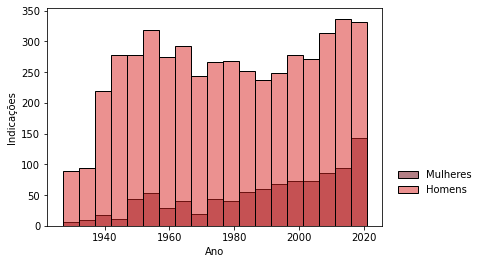

In [57]:
# INDICADOS E GANHADORES EM TODAS AS CATEGORIAS

g = sns.histplot(data=oscar_df, x='year', hue='gender', palette=[cmap_reds(0.7), cmap_reds(1.0)])
g.set(xlabel='Ano', ylabel='Indicações')
plt.legend(['Mulheres', 'Homens'], bbox_to_anchor=(1.02, 0.3), frameon=False)
plt.show()
# plt.savefig('../images/categories_all.png', dpi=250)

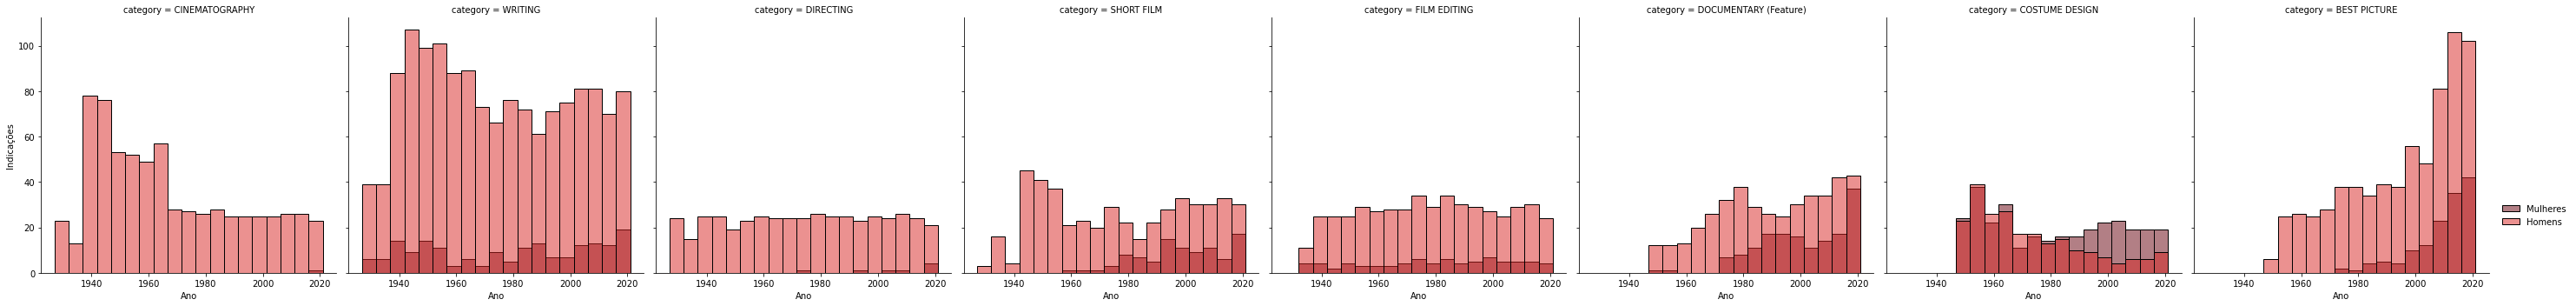

In [59]:
# INDICADOS POR CATEGORIA, colunas não empilhadas
g = sns.displot(data=oscar_df, x='year', hue='gender', col='category', legend=False, palette=[cmap_reds(0.7), cmap_reds(1.0)])
g.set(xlabel='Ano', ylabel='Indicações')
plt.legend(['Mulheres', 'Homens'], bbox_to_anchor=(1.02, 0.3), frameon=False)
plt.show()
# g.savefig('../images/categories.png', dpi=250)

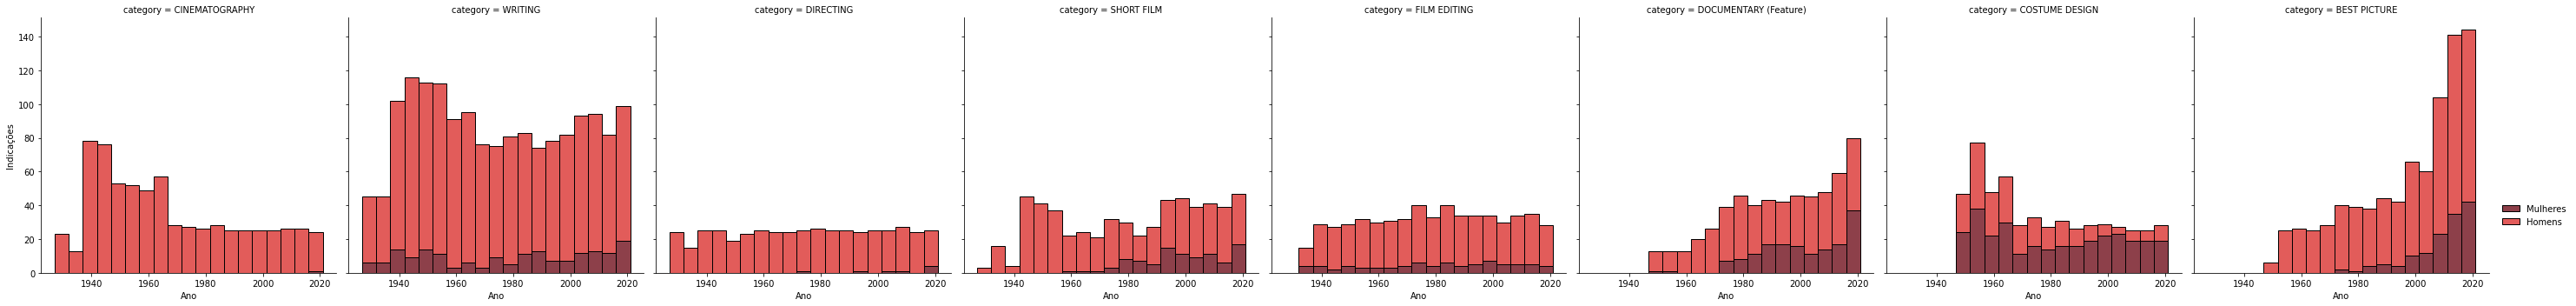

In [60]:
# INDICADOS POR CATEGORIA, colunas empilhadas
g = sns.displot(data=oscar_df, x='year', hue='gender', col='category', multiple='stack', legend=False, palette=[cmap_reds(0.7), cmap_reds(1.0)])
g.set(xlabel='Ano', ylabel='Indicações')
plt.legend(['Mulheres', 'Homens'], bbox_to_anchor=(1.02, 0.3), frameon=False)
plt.show()
# g.savefig('../images/categories_nominated_stack.png', dpi=250)